## Hypothesis Testing

This notebook tests:  
- Temporal stability check
- Primary hypothesis: conversion rate differs between control and treatment
- ITT vs PP impact (dilution)
- Segment-level heterogeneous effects with multiple-testing correction
- Bayesian AB: posterior + probabilities + credible interval

### Load data + define populations (ITT / PP)
Definitions 
- ITT (Intent-to-Treat): all assigned users (control + treatment), regardless of exposure.  
- PP (Per-Protocol): only users who actually received the intended experience.

In this case:  
- ITT: all dataset   
- PP:  
    - control: exposure_count == 0   
    - treatment: exposure_count >= 1


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.proportion as prop
from scipy.stats import chi2, chi2_contingency, fisher_exact
from statsmodels.stats.proportion import confint_proportions_2indep
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import NormalIndPower
# Load raw data
path = "../data/processed/ab_enriched.csv"
df_raw = pd.read_csv(path)

df = df_raw.copy()

segment_cols = ["device_type", "geo_region", "is_returning_user"]
for c in segment_cols:
    df[c] = df[c].astype("category")
    
df_itt = df.copy()

df_pp = df[
    ((df.group == 'control') & (df.exposure_count == 0)) |
    ((df.group == 'treatment') & (df.exposure_count >= 1))
].copy()

### Temporal stability check: daily uplift

In [26]:
sns.set_theme(style="whitegrid")


def _prep_dates(df, ts_col="timestamp"):
    d = df.copy()
    d[ts_col] = pd.to_datetime(d[ts_col])
    d["date"] = d[ts_col].dt.date
    return d
def daily_conversion_table(df, ts_col="timestamp", group_col="group", y_col="converted"):
    d = _prep_dates(df, ts_col)

    daily_cr = d.groupby(["date", group_col])[y_col].mean().unstack()
    daily_n  = d.groupby(["date", group_col])[y_col].size().unstack().add_prefix("n_")

    out = daily_cr.join(daily_n, how="left")

    if "treatment" in daily_cr.columns and "control" in daily_cr.columns:
        out["uplift"] = daily_cr["treatment"] - daily_cr["control"]

    return out.sort_index()

daily_tbl = daily_conversion_table(df_itt)
display(daily_tbl.head(10))

group,control,treatment,n_control,n_treatment,uplift
date,,,,,
2017-01-02,0.125568,0.119874,2859,2853,-0.005695
2017-01-03,0.113809,0.113781,6590,6618,-0.000028
2017-01-04,0.121922,0.116649,6578,6541,-0.005273
2017-01-05,0.123230,0.114988,6427,6505,-0.008242
2017-01-06,0.115350,0.123462,6606,6747,0.008113
2017-01-07,0.120987,0.116205,6604,6609,-0.004782
2017-01-08,0.118887,0.120746,6687,6700,0.001859
2017-01-09,0.119644,0.118065,6628,6615,-0.001579
2017-01-10,0.112864,0.126344,6654,6696,0.013480


C:\Users\olena\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\olena\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


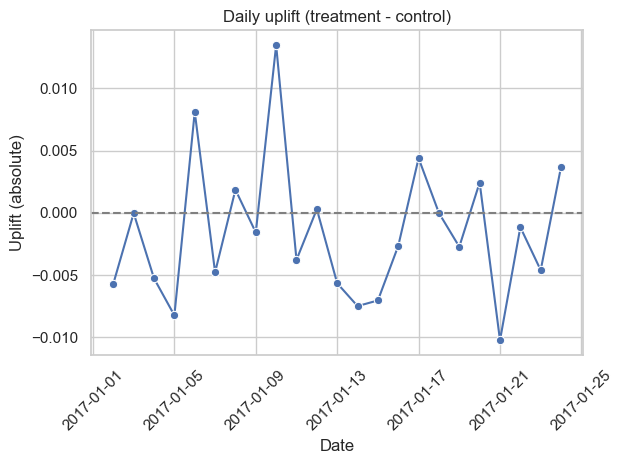

In [39]:
def plot_daily_uplift(daily_tbl):
    if "uplift" not in daily_tbl.columns:
        print("No uplift column.")
        return
    
    plot_df = daily_tbl.reset_index()[["date", "uplift"]]
    
    plt.figure()
    ax = sns.lineplot(data=plot_df, x="date", y="uplift", marker="o")
    ax.axhline(0.0, linestyle="--", color="gray")
    ax.set_title("Daily uplift (treatment - control)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Uplift (absolute)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_daily_uplift(daily_tbl)



In [35]:
daily_tbl["uplift"].mean(), daily_tbl["uplift"].std()

(-0.0015961600623080317, 0.005555605222742487)

Daily conversion differences fluctuate around zero with no consistent sign
or temporal pattern. Both positive and negative daily uplifts are observed,
while group sizes remain balanced across days.


This behavior is consistent with random variation in the absence of a true
treatment effect and does not indicate time-based bias, novelty effects,
or Simpson’s paradox.


The average daily effect was close to zero and much smaller than day-to-day
variance, which is exactly what we expect when there is no stable effect and
no time-based bias
### Primary metric estimation + Primary hypothesis test: difference in proportion
H_0: p_control = p_treatment  
H_1: p_control ≠ treatment  
Define :  
- ALPHA = 0.05  
- MPE (minimum practical effect) as +0.3 pp absolute conversion lift.

In [18]:
def primary_metric_estimation(dt: pd.DataFrame):
        g=dt.groupby("group")["converted"].agg(["mean",'sum',"count"])
        p_control,p_treatment=g["mean"]
        x_control,x_treatment=g['sum']
        n_control,n_treatment=g["count"]
        abs_dp = p_treatment - p_control
        rel_uplift = abs_dp / p_control if p_control > 0 else np.nan
        oddsA = p_control / (1 - p_control) if 0 < p_control < 1 else np.nan
        oddsB = p_treatment / (1 - p_treatment) if 0 < p_treatment < 1 else np.nan
        oratio = oddsB / oddsA if oddsA and oddsB else np.nan
        ci_low, ci_high = confint_proportions_2indep(count1=x_treatment, nobs1=n_treatment,count2=x_control, 
                                                    nobs2=n_control,method="newcomb" )
       
        title = " Primary metric estimation "
        print(f"\n{title:=^40}")
        print(f"{'Conversion Rate where group=control:':<25} {p_control:>12.2%}")
        print(f"{'Conversion Rate where group=treatment:':<25} {p_treatment:>12.2%}")
        print(f"{'-'*40}")
        print(f"{'Absolute Difference:':<25} {abs_dp:>12.4f}")
        print(f"{'Relative Uplift:':<25} {rel_uplift:>12.2%}")
        print(f"{'Odds Ratio (OR):':<25} {oratio:>12.4f}")
        print(f"{'Confidence Interval (CI): ['}{ci_low:>12.4f}{','}{ci_high:>12.4f} {']':<2}")
        print(f"{'='*40}\n")
        
        return p_control,p_treatment,abs_dp,rel_uplift,oratio,ci_low, ci_high
    
def primary_hypothesis_test(dt: pd.DataFrame):
        ct = pd.crosstab(dt['group'], dt['converted'])
            
        # Статистичний тест
        test_type = "Chi2"
        if (ct < 5).any().any():
            _, p = fisher_exact(ct)
            test_type = "Fisher"
        else:
             _, p, _, _ = chi2_contingency(ct)
                
        if p < ALPHA: 
            print(f"{'Significant '} {test_type} {'test (p_value= '} {p:>12.4f}{' )'}")
        else: print(f"{'Not significant '} {test_type} {'test (p_value='} {p:>12.4f}{')'}")
            
        return test_type, p
def calculate_sample_size(baseline_cr, mde_relative, alpha=0.05, power=0.8):
        """
        baseline_cr:current conversion (e.g. 0.1204)
        mde_relative: the relative increment we want to capture (e.g. 0.05 for 5%)
        """
        
        # 1. Визначаємо цільову конверсію
        target_cr = baseline_cr * (1 + mde_relative)
    
        # 2. Розраховуємо Effect Size (коефіцієнт Коена h)
        # Це стандартна міра для порівняння двох часток
    
        effect_size = prop.proportion_effectsize(baseline_cr, target_cr)
    
        # 3. Розрахунок розміру вибірки для ОДНІЄЇ групи
        analysis = NormalIndPower()
        sample_size = analysis.solve_power(effect_size=effect_size, 
                                       alpha=alpha, 
                                       power=power, 
                                       ratio=1.0)
    
        return int(np.ceil(sample_size))
    
def decision_rule(p_control,abs_dp,ci_low,ci_high,mpe,ALPHA=0.05):
       
        if ci_low >= mpe:
            decision = "SHIP"
        elif ci_high < 0:
            decision = "DO NOT SHIP (harm likely)"
        elif abs(abs_dp) < mpe and (ci_low <= 0 <= ci_high):
            decision = f"INCONCLUSIVE: effect < MPE or too noisy (consider rerun or bigger sample). Required number of users per group: "
            # Conservative rule: require entire CI to exceed MPE
            if p_control < 1e-6: 
                decision = decision + "cannot compute"
            else:
                mpe_rel = mpe / p_control
                # Sample size calculation assumes relative MDE.
                # Absolute MPE was converted to relative scale for approximation.
                required_n = calculate_sample_size(p_control, mpe_rel,ALPHA)
                decision = decision+ f"{required_n:,}"
        else:
            decision = "REVIEW: borderline vs MPE (consider business context)"
        print(decision)  
         



In [41]:

ALPHA = 0.05
MPE = 0.003 
p_control,p_treatment,abs_dp,rel_uplift,oratio,ci_low, ci_high= primary_metric_estimation(df_itt)
test_type, p= primary_hypothesis_test(df_itt)
decision_rule(p_control,abs_dp,ci_low,ci_high,MPE,ALPHA)




====== Primary metric estimation =======
Conversion Rate where group=control:       12.04%
Conversion Rate where group=treatment:       11.88%
----------------------------------------
Absolute Difference:           -0.0016
Relative Uplift:                -1.31%
Odds Ratio (OR):                0.9851
Confidence Interval (CI): [     -0.0039,      0.0008 ] 

Not significant  Chi2 test (p_value=       0.1918)
INCONCLUSIVE: effect < MPE or too noisy (consider rerun or bigger sample). Required number of users per group: 186,675


### ITT vs PP comparison (dilution analysis)
Checklist:  
- repeat section "Primary metric estimation + Primary hypothesis test" for df_pp  
- compare Δ_ITT vs Δ_PP  
- interpret dilution

In [42]:
p_control_pp,p_treatment_pp,abs_dp_pp,rel_uplift_pp,oratio_pp,ci_low_pp, ci_high_pp= primary_metric_estimation(df_pp)
test_type_pp, p_pp= primary_hypothesis_test(df_pp)
decision_rule(p_control_pp,abs_dp_pp,ci_low_pp,ci_high_pp,MPE,ALPHA)


====== Primary metric estimation =======
Conversion Rate where group=control:       12.04%
Conversion Rate where group=treatment:       11.81%
----------------------------------------
Absolute Difference:           -0.0023
Relative Uplift:                -1.89%
Odds Ratio (OR):                0.9786
Confidence Interval (CI): [     -0.0048,      0.0003 ] 

Not significant  Chi2 test (p_value=       0.0810)
INCONCLUSIVE: effect < MPE or too noisy (consider rerun or bigger sample). Required number of users per group: 186,675


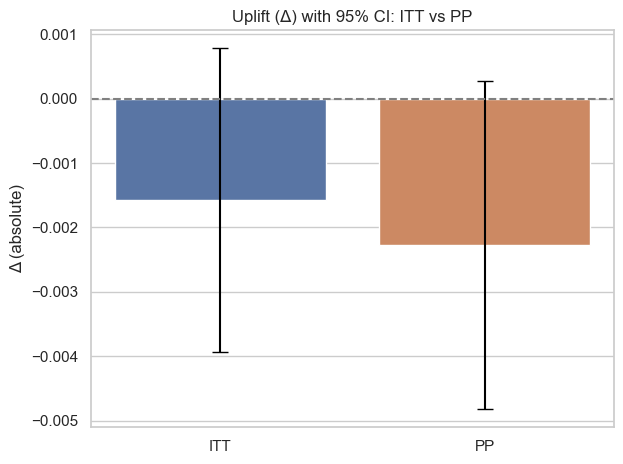

In [32]:
def make_uplift_ci_df(itt_delta, itt_ci_low, itt_ci_high,
                     pp_delta=None,  pp_ci_low=None,  pp_ci_high=None):
    rows = [{
        "estimand": "ITT",
        "delta": itt_delta,
        "ci_low": itt_ci_low,
        "ci_high": itt_ci_high
    }]
    if pp_delta is not None:
        rows.append({
            "estimand": "PP",
            "delta": pp_delta,
            "ci_low": pp_ci_low,
            "ci_high": pp_ci_high
        })
    return pd.DataFrame(rows)

def plot_itt_pp_uplift(uplift_ci_df, in_pp=True):
    d = uplift_ci_df.copy()

    plt.figure()
    ax = sns.barplot(data=d, x="estimand", y="delta", errorbar=None)

    # error bars
    for i, row in d.reset_index(drop=True).iterrows():
        ax.errorbar(
            x=i,
            y=row["delta"],
            yerr=[[row["delta"] - row["ci_low"]], [row["ci_high"] - row["delta"]]],
            fmt="none",
            capsize=6,
            color="black"
        )

    ax.axhline(0.0, linestyle="--", color="gray")
    ax.set_title("Uplift (Δ) with 95% CI: ITT vs PP")
    ax.set_xlabel("")
    ax.set_ylabel("Δ (absolute)")
    plt.tight_layout()
    plt.show()

uplift_ci_df = make_uplift_ci_df(abs_dp,ci_low,ci_high,abs_dp_pp,ci_low_pp,ci_high_pp)
plot_itt_pp_uplift(uplift_ci_df)

In [6]:
def interpret_dilution(delta_itt, delta_pp, eps=0.001, ratio_tol=0.25):
    """
    Interpret ITT vs PP comparison.

    eps        : threshold for 'approximately zero' (absolute, in probability units)
    ratio_tol  : relative tolerance for considering ITT ~ PP
                 e.g. 0.25 → within ±25%
    """

    # Both essentially zero
    if abs(delta_itt) < eps and abs(delta_pp) < eps:
        return (
            "Both ITT and PP lifts are approximately zero, "
            "indicating no evidence of a meaningful treatment effect."
        )

    # ITT ≈ PP (negligible dilution)
    if abs(delta_itt - delta_pp) <= max(eps, ratio_tol * abs(delta_itt)):
        return (
            "The PP estimand yields results nearly identical to ITT, "
            "indicating that treatment exposure was effectively aligned "
            "with assignment and that dilution is negligible in this experiment."
        )

    # Dilution case: PP >> ITT
    if abs(delta_pp) > abs(delta_itt) + eps and (delta_pp * delta_itt >= 0):
        return (
            "PP lift is meaningfully larger than ITT, suggesting that "
            "the treatment effect may exist but is diluted in the ITT analysis "
            "due to exposure or eligibility issues."
        )

    # Suspicious case: ITT > PP
    if abs(delta_itt) > abs(delta_pp) + eps and (delta_pp * delta_itt >= 0):
        return (
            "ITT lift exceeds PP lift, which is unexpected. "
            "This may indicate issues with PP definition, selection bias, "
            "or incorrect exposure logic."
        )

    # Sign flip
    if delta_itt * delta_pp < 0:
        return (
            "ITT and PP lifts have opposite signs, suggesting potential "
            "selection bias or misalignment in PP filtering."
        )

    return (
        "Mixed ITT vs PP pattern detected. "
        "Interpret cautiously and review exposure logic and sample sizes."
    )
interpret_dilution(abs_dp, abs_dp_pp)

'The PP estimand yields results nearly identical to ITT, indicating that treatment exposure was effectively aligned with assignment and that dilution is negligible in this experiment.'

### Segment-level heterogeneous effects (HTE)
 - Logistic regression interaction test for each segment (3 tests)
 - Holm correction across these 3 p-values
 - Post-hoc uplift-by-level ONLY for segments with significant interaction


In [20]:
# ----------------------------
#Logistic interaction test (LRT) for one segment
# ----------------------------
def fit_logit_models_for_segment(dt: pd.DataFrame, segment_col: str):
    """
    Fit:
      reduced: converted ~ treat + C(segment)
      full:    converted ~ treat * C(segment)
    Return fitted models.
    """
    data=dt.copy()
    data["treat"] = (data["group"] == "treatment").astype(int)
    reduced = smf.logit(f"converted ~ treat + C({segment_col})", data=data).fit(disp=False)
    full = smf.logit(f"converted ~ treat * C({segment_col})", data=data).fit(disp=False)
    return reduced, full


def lrt_pvalue(reduced_model, full_model):
    """
    Likelihood ratio test for nested models:
      LR = 2*(LL_full - LL_reduced) ~ Chi2(df_diff)
    """
    lr_stat = 2.0 * (full_model.llf - reduced_model.llf)
    df_diff = int(full_model.df_model - reduced_model.df_model)
    pval = 1.0 - chi2.cdf(lr_stat, df_diff)
    return lr_stat, df_diff, pval


def interaction_first_tests(dt: pd.DataFrame, seg_cols: list[str]):
    """
    Run interaction LRT for each segment column.
    Returns:
      - results_df: segment, lr_stat, df, p_interaction
      - models_full: dict segment-> full model
    """
    rows = []
    models_full = {}
    for seg in seg_cols:
        red, full = fit_logit_models_for_segment(dt, seg)
        lr_stat, df_diff, p = lrt_pvalue(red, full)
        models_full[seg] = full
        rows.append({"segment": seg, "lr_stat": lr_stat, "df": df_diff, "p_interaction": p})
    results_df = pd.DataFrame(rows).sort_values("p_interaction")
    return results_df, models_full
def interaction(dt: pd.DataFrame, seg_cols: list[str],ALPHA):
    interaction_df, full_models = interaction_first_tests(dt, segment_cols)

    # Holm correction across the 3 interaction p-values
    interaction_df["p_adj_holm"] = multipletests(interaction_df["p_interaction"], method="holm")[1]
    interaction_df["interaction_significant"] = interaction_df["p_adj_holm"] < ALPHA

    
    return interaction_df,full_models
interaction_df,full_model=interaction(df_itt, segment_cols,ALPHA)
print("\n=== Interaction-first tests (LRT) ===")
interaction_df


=== Interaction-first tests (LRT) ===


,segment,lr_stat,df,p_interaction,p_adj_holm,interaction_significant
2,is_returning_user,0.711611,1,0.398909,1.0,False
0,device_type,0.185230,1,0.666917,1.0,False
1,geo_region,0.255636,2,0.880014,1.0,False


In [21]:
# ----------------------------
# 3) Post-hoc uplift by level (only if interaction significant)
# ----------------------------
def posthoc_uplift_by_level(dt: pd.DataFrame, segment_col: str, full_model):
    """
    Compute predicted conversion probabilities for treat=0 and treat=1
    at each level of a segment, based on the fitted full interaction model.

    Returns a DataFrame with p_control, p_treat, lift_pp.
    """
    levels = dt[segment_col].cat.categories

    out = []
    for lvl in levels:
        # Build prediction frame
        pred_df = pd.DataFrame({
            "treat": [0, 1],
            segment_col: pd.Categorical([lvl, lvl], categories=levels)
        })
        # The model formula includes C(segment_col), so column names must match
        preds = full_model.predict(pred_df)
        p0, p1 = float(preds.iloc[0]), float(preds.iloc[1])
        out.append({
            "segment": segment_col,
            "level": str(lvl),
            "p_control_pred": p0,
            "p_treat_pred": p1,
            "lift_pp_pred": (p1 - p0) * 100.0
        })

    return pd.DataFrame(out).sort_values("lift_pp_pred", ascending=False)


#significant_segments = interaction_df.loc[interaction_df["interaction_significant"], "segment"].tolist()
def print_post_hoc(dt: pd.DataFrame, interaction_df, models: dict):
    significant_segments = interaction_df.loc[interaction_df["interaction_significant"], "segment"].tolist()
    print("\n=== Post-hoc uplift by level (only for significant interactions) ===")
    if len(significant_segments) == 0:
        print("No segment interactions remain significant after Holm correction.")
    else:
        for seg in significant_segments:
            ph = posthoc_uplift_by_level(dt, seg, models[seg])
            print(f"\n-- Segment: {seg} (interaction significant after Holm) --")
            print(ph)



print_post_hoc(df_itt, interaction_df, full_model)


=== Post-hoc uplift by level (only for significant interactions) ===
No segment interactions remain significant after Holm correction.


### Bayesian AB: posterior + probabilities + credible interval

In [9]:
import numpy as np
import pandas as pd


def get_counts(df):
    A = df[df["group"]=="control"]["converted"].astype(int)
    B = df[df["group"]=="treatment"]["converted"].astype(int)
    nA, xA = int(A.count()), int(A.sum())
    nB, xB = int(B.count()), int(B.sum())
    return nA, xA, nB, xB


# ITT
nA_itt, xA_itt, nB_itt, xB_itt = get_counts(df_itt)


print("ITT counts:", (nA_itt, xA_itt, nB_itt, xB_itt))

ITT counts: (145274, 17489, 145310, 17264)


In [10]:
from dataclasses import dataclass

@dataclass
class BayesAB:
    prior_name: str
    a: float
    b: float
    mpe: float
    draws: int
    pA_mean: float
    pB_mean: float
    delta_mean: float
    delta_ci: tuple[float, float]
    p_delta_gt_0: float
    p_delta_ge_mpe: float

def bayes_ab_beta_binomial(nA, xA, nB, xB, mpe=0.003, a=1.0, b=1.0, draws=200_000, seed=42, prior_name="Beta(1,1)"):
    """
    Bayesian A/B for conversion using Beta-Binomial conjugacy.
    Returns posterior summaries for p_control, p_treat and delta = p_treat - p_control.
    """
    rng = np.random.default_rng(seed)

    # Posterior params
    aA, bA = a + xA, b + (nA - xA)
    aB, bB = a + xB, b + (nB - xB)

    # Draw posterior samples
    pA = rng.beta(aA, bA, size=draws)
    pB = rng.beta(aB, bB, size=draws)
    delta = pB - pA

    # Summaries
    pA_mean = float(pA.mean())
    pB_mean = float(pB.mean())
    delta_mean = float(delta.mean())
    ci_low, ci_high = np.quantile(delta, [0.025, 0.975])

    p_gt_0 = float((delta > 0).mean())
    p_ge_mpe = float((delta >= mpe).mean())

    return BayesAB(
        prior_name=prior_name,
        a=a, b=b,
        mpe=mpe, draws=draws,
        pA_mean=pA_mean,
        pB_mean=pB_mean,
        delta_mean=delta_mean,
        delta_ci=(float(ci_low), float(ci_high)),
        p_delta_gt_0=p_gt_0,
        p_delta_ge_mpe=p_ge_mpe
    )

In [43]:

res_u = bayes_ab_beta_binomial(nA_itt, xA_itt, nB_itt, xB_itt, mpe=MPE, a=1, b=1, prior_name="Beta(1,1)")
res_j = bayes_ab_beta_binomial(nA_itt, xA_itt, nB_itt, xB_itt, mpe=MPE, a=0.5, b=0.5, prior_name="Beta(0.5,0.5)")

def pretty_bayes(res: BayesAB):
    lo, hi = res.delta_ci
    return (
        f"{res.prior_name}\n"
        f"Posterior means: pA={res.pA_mean:.6f}, pB={res.pB_mean:.6f}\n"
        f"Δ mean={res.delta_mean:+.6f} ({res.delta_mean*100:+.3f} pp)\n"
        f"95% CrI for Δ: [{lo:+.6f}, {hi:+.6f}] ([{lo*100:+.3f}, {hi*100:+.3f}] pp)\n"
        f"P(Δ>0)={res.p_delta_gt_0:.3f} | P(Δ>=MPE={res.mpe*100:.2f} pp)={res.p_delta_ge_mpe:.3f}\n"
    )

print(pretty_bayes(res_u))
print(pretty_bayes(res_j))

Beta(1,1)
Posterior means: pA=0.120390, pB=0.118815
Δ mean=-0.001575 (-0.157 pp)
95% CrI for Δ: [-0.003933, +0.000798] ([-0.393, +0.080] pp)
P(Δ>0)=0.095 | P(Δ>=MPE=0.30 pp)=0.000

Beta(0.5,0.5)
Posterior means: pA=0.120388, pB=0.118813
Δ mean=-0.001575 (-0.157 pp)
95% CrI for Δ: [-0.003933, +0.000798] ([-0.393, +0.080] pp)
P(Δ>0)=0.095 | P(Δ>=MPE=0.30 pp)=0.000



In [34]:
def bayes_markdown_summary(res: BayesAB) -> str:
    lo, hi = res.delta_ci
    return f"""
        ### Bayesian decision add-on ({res.prior_name})


        Posterior mean uplift: **Δ = {res.delta_mean*100:+.3f} pp**
        95% credible interval: **[{lo*100:+.3f}, {hi*100:+.3f}] pp**


        Decision probabilities:
        - **P(Δ > 0 | data) = {res.p_delta_gt_0:.3f}**
        - **P(Δ>= MPE={res.mpe*100:.2f} pp | data) = {res.p_delta_ge_mpe:.3f}**

        """

print(bayes_markdown_summary(res_j))


        ### Bayesian decision add-on (Beta(0.5,0.5))


        Posterior mean uplift: **Δ = -0.157 pp**
        95% credible interval: **[-0.393, +0.080] pp**


        Decision probabilities:
        - **P(Δ > 0 | data) = 0.095**
        - **P(Δ>= MPE=0.30 pp | data) = 0.000**

        


Assuming 1 million users visits per month and conversion value = €5,  
to calculate expected value of shipping ≈ E[Δ] * monthly_users * value_per_conversion

In [13]:
def expected_value_of_shipping(res: BayesAB, monthly_users=1_000_000, value_per_conversion=5.0):
    # EV ≈ E[Δ] * N * value
    return res.delta_mean * monthly_users * value_per_conversion


ev = expected_value_of_shipping(res_j, monthly_users=1_000_000, value_per_conversion=5.0)
print("EV shipping (approx):", round(ev, 2))

EV shipping (approx): -7874.63


## Conclusions

The estimated ITT uplift is Δ = -0.156 pp with a 95% confidence interval [-0.393, +0.080] pp.  
The null hypothesis of no effect cannot be rejected at ALPHA = 0.05.

This indicates that the observed difference is compatible with random variation, and the data does not provide strong statistical evidence of a non-zero effect.The experiment was underpowered to detect effects below 0.3 pp,
so small effects cannot be ruled out.

The PP estimand yields results nearly identical to ITT, indicating that treatment exposure was effectively aligned with assignment and that dilution is negligible in this experiment.

Segment-level interaction tests did not reveal statistically significant heterogeneous treatment effects after multiple-testing correction. This suggests that the treatment effect is approximately homogeneous across examined segments.

As a result, there is no statistical evidence suggesting Simpson’s paradox in this experiment, and the overall ITT effect can be interpreted as a reliable summary of segment-level behavior.

However, small undetected heterogeneity cannot be fully ruled out due to power limitations for interaction tests.

Bayesian posterior assigns only ~9.5% probability to a positive effect and virtually zero probability to exceeding the MPE. EV is negative under assumed traffic/value.

Recommended action: Do not ship globally.    
Consider:
- targeted rollout
- design iteration
- or longer experiment with higher exposure

Reasons:  
- evidence: CI includes 0 and below MPE  
- bayes: P(delta>0) low, P(delta>=MPE) near 0  
- economics: EV negative

Limitations:
- The experiment was underpowered to detect effects below 0.3 pp.
- Interaction tests may miss small heterogeneous effects.
- Results apply to the observed traffic mix and time window.